In [10]:
import yaml
import torch
from pathlib import Path
from data.dataset_utils import get_data_loaders
from model.resnet50 import ResNet50Classifier, GradCAM
from training.train import train
from eval.evaluate import evaluate
from inference.diagnose import classify_image
import kagglehub
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
### load data

path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

100%|██████████| 1.36G/1.36G [02:25<00:00, 10.0MB/s]

Extracting files...


Path to dataset files: /Users/tobiaspfeiffer/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6


In [4]:
### load parameters

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
### test train split

train_loader, val_loader, class_names = get_data_loaders(
    data_dir=f"{path}/SkinDisease/SkinDisease/train",
    exclude_classes=config["excluded_classes"],
    batch_size=config["batch_size"],
    val_split=config["val_split"],
    input_size=config["input_size"]
)

In [12]:
#### initialize model

model = ResNet50Classifier(num_classes=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/tobiaspfeiffer/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.55MB/s]


In [13]:
### train model

train(
    model,
    train_loader,
    val_loader,
    device=device,
    lr=config["learning_rate"],
    epochs=config["num_epochs"],
    save_path=config["model_path"]
)

Epoch 1/10, Train Loss: 0.7272
Validation Loss: 0.6588
Epoch 2/10, Train Loss: 0.5849
Validation Loss: 0.6201
Epoch 3/10, Train Loss: 0.5498
Validation Loss: 0.6049
Epoch 4/10, Train Loss: 0.5185
Validation Loss: 0.6094
Epoch 5/10, Train Loss: 0.5096
Validation Loss: 0.5715
Epoch 6/10, Train Loss: 0.4944
Validation Loss: 0.5910
Epoch 7/10, Train Loss: 0.4810
Validation Loss: 0.5746
Epoch 8/10, Train Loss: 0.4848
Validation Loss: 0.5620
Epoch 9/10, Train Loss: 0.4625
Validation Loss: 0.5637
Epoch 10/10, Train Loss: 0.4624
Validation Loss: 0.5528
Model saved to resnet50_best.pth


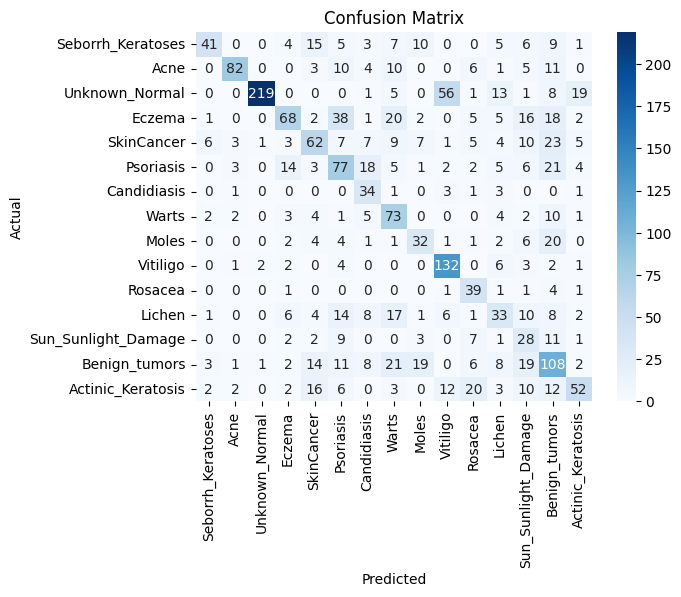

                     precision    recall  f1-score   support

  Seborrh_Keratoses       0.73      0.39      0.51       106
               Acne       0.86      0.62      0.72       132
     Unknown_Normal       0.98      0.68      0.80       323
             Eczema       0.62      0.38      0.47       178
         SkinCancer       0.48      0.41      0.44       153
          Psoriasis       0.41      0.48      0.44       161
        Candidiasis       0.38      0.77      0.51        44
              Warts       0.42      0.68      0.52       107
              Moles       0.43      0.43      0.43        74
           Vitiligo       0.62      0.86      0.72       153
            Rosacea       0.41      0.81      0.55        48
             Lichen       0.35      0.30      0.32       111
Sun_Sunlight_Damage       0.23      0.44      0.30        64
      Benign_tumors       0.41      0.48      0.44       223
  Actinic_Keratosis       0.57      0.37      0.45       140

           accuracy   

In [14]:
### evaluate model
evaluate(model, val_loader, class_names, device)

In [15]:
### inference

test_image_path = f"{path}/SkinDisease/SkinDisease/test/Vitiligo/images134.jpeg"
predicted = classify_image(test_image_path, config["model_path"], class_names, device)
print(f"Predicted skin disease: {predicted}")

image = Image.open(test_image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((config["input_size"], config["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(device)

target_layer = model.model.layer4[-1].conv3
gradcam = GradCAM(model.model, target_layer)
heatmap = gradcam.generate(input_tensor)

# unnormalize for display
img_vis = input_tensor[0].cpu().clone()
img_vis = img_vis - img_vis.min()
img_vis = img_vis / img_vis.max()

overlay = GradCAM.overlay(img_vis, heatmap)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_vis.permute(1, 2, 0).numpy())
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"GradCAM: {predicted}")
plt.axis("off")
plt.show()

/Users/tobiaspfeiffer/Desktop/Programming/finetune_resnet_for_skin_disease_clas/.sdc/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tobiaspfeiffer/Desktop/Programming/finetune_resnet_for_skin_disease_clas/.sdc/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted skin disease: Vitiligo


AttributeError: 'NoneType' object has no attribute 'mean'